# Imports

In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

# import wandb

In [2]:
# wandb.login()

In [3]:
# wandb_run = wandb.init(project="CovidPredictor")

# Utils

In [4]:
def compare(dataframe, fields):
    fig, ax = plt.subplots(figsize=(10,10))
    for f in fields:
        ax.plot(dataframe["Date"], dataframe[f], label=f)
    ax.legend(loc="best")

In [5]:
def mobility_check(df, where, what, everything=False, save=False):
    fig, ax = plt.subplots(figsize=(10,10))
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where]["new cases"].to_numpy().reshape(-1, 1)), label=f"Cases @ {where}")
    sc = StandardScaler()
    ll = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline',]
    if everything:
        for l in ll:
            ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where][l].to_numpy().reshape(-1, 1)), label=l)
    else:
        ax.plot(df[df["State"]==where]["Date"], sc.fit_transform(df[df["State"]==where][what].to_numpy().reshape(-1, 1)), label=what)
    ax.legend(loc="best")
    if save:
        plt.savefig(f"{where},{what if not everything else ''}.png")

# Data Collection and Analysis

In [6]:
df = pd.read_csv("data/state_mobility_cases_agg=max_2020.csv")
df["Date"]=pd.to_datetime(df["Date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10523 entries, 0 to 10522
Data columns (total 9 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   Date                                                10523 non-null  datetime64[ns]
 1   State                                               10523 non-null  object        
 2   retail_and_recreation_percent_change_from_baseline  10176 non-null  float64       
 3   grocery_and_pharmacy_percent_change_from_baseline   9870 non-null   float64       
 4   parks_percent_change_from_baseline                  10448 non-null  float64       
 5   transit_stations_percent_change_from_baseline       10171 non-null  float64       
 6   workplaces_percent_change_from_baseline             10520 non-null  float64       
 7   residential_percent_change_from_baseline            10254 non-null  float64       
 8   new cas

In [7]:
scaler = StandardScaler()
scaled_df = df.copy()
df_no_date_no_place = df.drop(["Date", "State"], axis=1)
scaled_df[df_no_date_no_place.columns] = scaler.fit_transform(df[df_no_date_no_place.columns])
scaled_df

,Date,State,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,new cases
0,2020-03-14,Andaman and Nicobar Islands,0.291569,-0.774992,-0.395025,-0.181550,-0.108450,-1.549277,-0.467251
1,2020-03-14,Andhra Pradesh,0.674130,-0.387750,-0.175257,-0.060094,-0.170492,-1.793147,-0.466772
2,2020-03-14,Arunachal Pradesh,0.817591,-0.559858,0.122999,-0.181550,0.356866,-1.915082,-0.467251
3,2020-03-14,Assam,0.793681,-0.373408,0.028813,0.349821,0.387887,-1.915082,-0.467251
4,2020-03-14,Bihar,0.961052,-0.100905,0.264278,0.273911,0.170739,-0.939603,-0.467251
...,...,...,...,...,...,...,...,...,...
10518,2020-12-31,Telangana,0.793681,0.773975,0.044510,0.243547,0.108697,-0.939603,-0.268683
10519,2020-12-31,Tripura,0.554580,0.071203,0.750907,1.169650,0.791160,-0.939603,-0.464380
10520,2020-12-31,Uttar Pradesh,1.080602,1.448062,0.829395,0.440913,0.698097,0.035877,-0.467251
10521,2020-12-31,Uttarakhand,1.869635,0.702263,1.818350,1.518837,0.915244,-0.207993,-0.321794


/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/sit

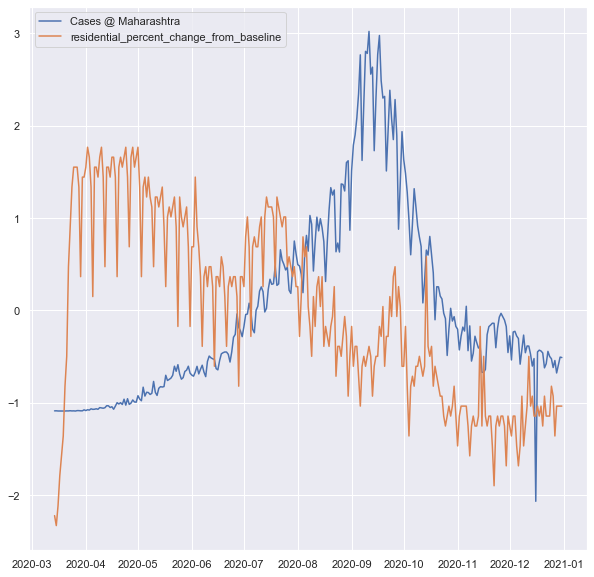

In [8]:
mobility_check(scaled_df,"Maharashtra", "residential_percent_change_from_baseline")

/Users/sharadchitlangia/miniconda3/envs/dreamcoder/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


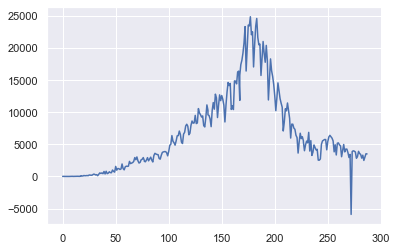

In [203]:
# mobility_check(df, "Maharashtra", "residential_percent_change_from_baseline")
plt.plot(df[df['State']=='Maharashtra']['Date'],df[df['State']=='Maharashtra']['new cases'])

# Algorithm Developement

In [39]:
def sliding_window(data, seq_len, j=0):

    xs = []
    ys = []
    for i in range(len(data)-seq_len-1-j):
        x = data[i:(i+seq_len)].drop(["Date"], axis=1).to_numpy()
        y = data[(i+seq_len):i+seq_len+1+j]["new cases"].to_numpy().flatten()#[0]
        xs.append(x)
        ys.append(y)

  
    return np.array(xs, dtype=np.float64), np.array(ys, dtype=np.float64)

In [182]:
df["Date"] = df["Date"].dt.year * 30 * 12 +df["Date"].dt.month * 30 + df["Date"].dt.day
df["Date"] -= df["Date"].min()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 14, 7)]      0                                            
__________________________________________________________________________________________________
lstm_43 (LSTM)                  [(None, 100), (None, 43200       input_57[0][0]                   
__________________________________________________________________________________________________
repeat_vector_10 (RepeatVector) (None, 4, 100)       0           lstm_43[0][0]                    
__________________________________________________________________________________________________
lstm_44 (LSTM)                  (None, 4, 100)       80400       repeat_vector_10[0][0]           
                                                                 lstm_43[0][0]             

6/6 [==============================] - 0s 53ms/step - loss: 5685256.8571 - mae: 1451.3412 - val_loss: 10128031.0000 - val_mae: 2663.6560
Epoch 45/120
6/6 [==============================] - 0s 50ms/step - loss: 8979246.0000 - mae: 1795.0933 - val_loss: 10794963.0000 - val_mae: 2723.6301
Epoch 46/120
6/6 [==============================] - 0s 46ms/step - loss: 8860575.5714 - mae: 1754.9069 - val_loss: 6621598.0000 - val_mae: 2071.2075
Epoch 47/120
6/6 [==============================] - 0s 56ms/step - loss: 7221868.7857 - mae: 1523.9256 - val_loss: 4487377.5000 - val_mae: 1668.1439
Epoch 48/120
6/6 [==============================] - 0s 69ms/step - loss: 7780501.2143 - mae: 1770.1098 - val_loss: 2918189.2500 - val_mae: 1306.4357
Epoch 49/120
6/6 [==============================] - 0s 88ms/step - loss: 6908431.8571 - mae: 1577.5702 - val_loss: 5429757.5000 - val_mae: 1830.5845
Epoch 50/120
6/6 [==============================] - 0s 65ms/step - loss: 5906049.6786 - mae: 1485.4982 - val_loss: 45

6/6 [==============================] - 0s 35ms/step - loss: 6424004.0000 - mae: 1518.3236 - val_loss: 2752931.0000 - val_mae: 1265.6974
Epoch 100/120
6/6 [==============================] - 0s 41ms/step - loss: 5951754.6429 - mae: 1545.4689 - val_loss: 4902883.0000 - val_mae: 1787.0675
Epoch 101/120
6/6 [==============================] - 0s 33ms/step - loss: 7159663.5714 - mae: 1602.8735 - val_loss: 6573646.5000 - val_mae: 2110.4343
Epoch 102/120
6/6 [==============================] - 0s 31ms/step - loss: 4962115.8571 - mae: 1360.4472 - val_loss: 2245071.2500 - val_mae: 1136.4381
Epoch 103/120
6/6 [==============================] - 0s 46ms/step - loss: 6803370.4286 - mae: 1587.1572 - val_loss: 4308003.5000 - val_mae: 1656.8842
Epoch 104/120
6/6 [==============================] - 0s 84ms/step - loss: 5828604.1786 - mae: 1334.0199 - val_loss: 5490388.5000 - val_mae: 1916.0610
Epoch 105/120
6/6 [==============================] - 0s 47ms/step - loss: 5258187.2857 - mae: 1322.1195 - val_loss

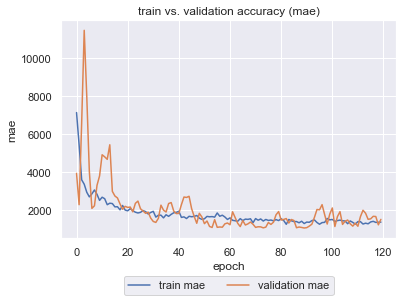

In [183]:
from tqdm.notebook import trange

r2_scores, test_error_mse, test_error_mae = [], [], []
train, test = {}, {}
train['feats'], train['pred'], train['true'] = {}, {}, {}
test['feats'], test['pred'], test['true'] = {}, {}, {}

n_hidden = 100

prev_days = 14
forecast_days = 4

df_custom = df[df["State"]=="Maharashtra"].drop("State", axis=1)


X, y = sliding_window(df_custom[df_custom['Date']<=250], prev_days, forecast_days-1)

input_train = keras.Input(shape=(prev_days, 7))
output_train = keras.Input(shape=(forecast_days, 1))

encoder_last_h1, encoder_last_h2, encoder_last_c = keras.layers.LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)

# encoder_last_h1 = keras.layers.BatchNormalization(momentum=0.6)(encoder_last_h1)
# encoder_last_c = keras.layers.BatchNormalization(momentum=0.6)(encoder_last_c)

decoder = keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = keras.layers.LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder)

model = keras.Model(inputs=input_train, outputs=out)
opt = keras.optimizers.Adam(lr=0.001, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

num_epochs = 120

epc = num_epochs
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X, y.reshape(-1,4,1), validation_split=0.2, 
                    epochs=epc, verbose=1, batch_size=32, callbacks=[es])
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

xt, yt = sliding_window(df_custom[df_custom['Date']>250], prev_days, forecast_days-1)

y_pred = model.predict(xt)

test_error_mae.append(mean_squared_error(yt, y_pred[:,:,0]))
test_error_mse.append(mean_absolute_error(yt, y_pred[:,:,0]))
r2_scores.append(r2_score(yt, y_pred[:,:,0]))            

# X, y = sliding_window(scaled_df[scaled_df["State"]=="West Bengal"].drop("State", axis=1), 1)

# r2_scores, test_error_mae, test_error_mse, train, test = train_model_with_crossval(
#     model, 
#     X, 
#     y,
#     tscv,
# )

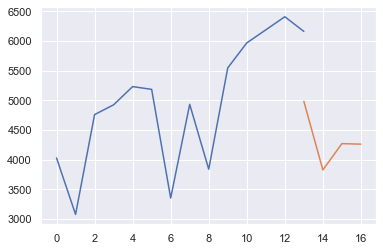

In [196]:
for index in range(30):
    plt.plot(np.arange(0,14), xt[index,:,-1], label='Previous')
    plt.plot(np.arange(14,18), yt[index,:], label='True')
    plt.plot(np.arange(14,18), y_pred[index,:], label='Forecasted')
    plt.legend()

    plt.show()

In [14]:
r2_scores, test_error_mae, test_error_mse

NameError: name 'r2_scores' is not defined